In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt

### Load Data

In [3]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AAPL = pd.read_csv('SPY.csv')
AAPL['Date'] = AAPL['Date'].astype('datetime64[ns]')
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,90.790062,118944600
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,91.030411,111579900
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,91.094490,116074400
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,91.479050,131091100
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,91.783432,126402800
...,...,...,...,...,...,...,...
2836,2021-04-12,410.850006,411.929993,410.200012,411.640015,411.640015,56704900
2837,2021-04-13,411.529999,413.529999,411.119995,412.859985,412.859985,56551000
2838,2021-04-14,412.829987,413.959991,410.869995,411.450012,411.450012,61659900
2839,2021-04-15,413.739990,416.160004,413.690002,415.869995,415.869995,60229800


In [4]:
AAPL.iloc[900]

Date         2013-08-01 00:00:00
Open                      169.99
High                      170.81
Low                        169.9
Close                     170.66
Adj Close                146.903
Volume                 110438400
Name: 900, dtype: object

# Visualize

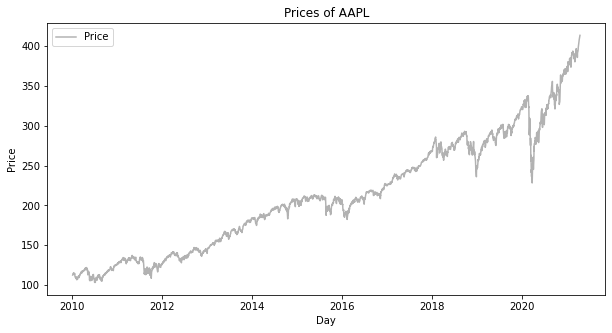

In [5]:
# Visualize prices from 2010 t0 2021
start = 0
end = -1

plt.figure(figsize=(10,5))
plt.plot(AAPL['Date'][start:end], AAPL[['Open']][start:end], label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices of AAPL')
plt.legend()
plt.show()

In [6]:
SMA20s = AAPL['Open'].rolling(window=20, center=False).mean()
SMA20s

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
2836    397.251502
2837    398.111502
2838    398.899501
2839    399.860001
2840    400.998500
Name: Open, Length: 2841, dtype: float64

In [7]:
SMA50s = AAPL['Open'].rolling(window=50, center=False).mean()

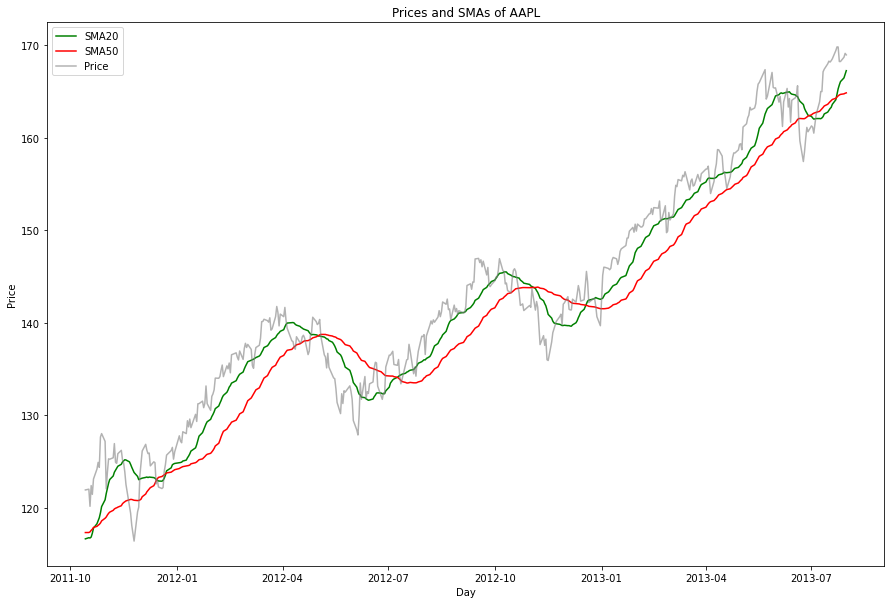

In [8]:
# Visualize SMAs and prices
plt.figure(figsize=(15,10))
plt.plot(AAPL[['Date']][450:900], SMA20s[450:900], label='SMA20', c='green')
plt.plot(AAPL[['Date']][450:900], SMA50s[450:900], label='SMA50', c='red')
plt.plot(AAPL[['Date']][450:900], AAPL[['Open']][450:900], label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices and SMAs of AAPL')
plt.legend()
plt.show()

From the plot, we can see when SMA20 meets SMA 50, it is a good indicator to either buy or sell stocks:
- When SMA20 becomes greater than SMA50: Buy signal
- When SMA20 becomes smaller than SMA20: Sell signal

### Building the Agent

In [9]:
# Determine when to excecute the strategies
class SMA_Agent:
    
    def __init__(self, wallet):
        self.data = None
        self.wallet = wallet # Amount of cash in hand
        self.portfolio = 0 # Company stock count
        self.current_market = None
        self.history = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        self.sma_diff = [] #
    
    # Check if the agent can buy the stock
    # Returns: Boolean. True if can buy, False if not
    def can_buy(self, unit):
        if unit == -1:
            if self.wallet >= self.current_market['Open']:
                return True
        else:
            if self.wallet >= unit*self.current_market['Open']:
                return True
        return False
    
    # Check if the agent can sell the stock
    # Returns: Boolean. True if can sell, False if not
    def can_sell(self, unit):
        if unit == -1:
            if self.portfolio > 0:
                return True
        else:
            if self.portfolio >= unit:
                return True
        return False
    
    # Buys x unit of stock. -1 to spend all
    def buy(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = math.floor(self.wallet/current_price)
        self.wallet -= unit*current_price
        self.portfolio += unit
        self.history[0][0].append(self.current_market['Date'])
        self.history[0][1].append(current_price)
    
    # Sells x unit of stock. -1 to sell all
    def sell(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = self.portfolio
        self.wallet += unit*current_price
        self.portfolio -= unit
        self.history[1][0].append(self.current_market['Date'])
        self.history[1][1].append(current_price)
    
    # Computes the total balance: wallet + holdings
    def total_balance(self):
        current_price = self.current_market['Open'] # price 1 stock
        return self.wallet + current_price*self.portfolio
    
    # Computes the "smooth moving average of past 50 days"
    def sma50(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.data['Open'].rolling(window=50, center=False).mean()[index]
    
    # Computes the "smooth moving average of past 20 days"
    def sma20(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.data['Open'].rolling(window=20, center=False).mean()[index]
    
    # Defines the buying/selling strategy
    # Buy when sma20 goes above sma50
    # Sell when sma20 goes below sma50
    def strategy(self):
        # first iteration
        sma20 = SMA_Agent.sma20(self)
        sma50 = SMA_Agent.sma50(self)
        new_sma_diff = sma20-sma50
        # first iteration
        if len(self.sma_diff) != 0:
            if sma20 > sma50 and self.sma_diff[-1] < 0 and SMA_Agent.can_buy(self,-1):
                # Buy signal
                SMA_Agent.buy(self,-1)
            elif sma20 < sma50 and self.sma_diff[-1] > 0 and SMA_Agent.can_sell(self,-1):
                # sell signal
                SMA_Agent.sell(self,-1)
        self.sma_diff.append(new_sma_diff)
    
    # Given a dataframe computes the buy and sell signals
    def deploy(self, data):
        self.data = data.reset_index()
        for (idx, row) in self.data.iterrows():
            self.current_market = data.iloc[idx]
            if idx > 49: # first day where SMA50 is computed
                SMA_Agent.strategy(self)
        return self.history

### Run and Evaluate Bot

In [13]:
# Inputs
invest = 10000
start_from = 2667-50
end_from = -1
data = AAPL[start_from:end_from]

agent = SMA_Agent(invest)
buy_info, sell_info = agent.deploy(data)

In [14]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 10000
End of day total balance: 12052.619970999998
Percentage gain: 20.526199709999982 %

Baseline: 35.80830400410249 %


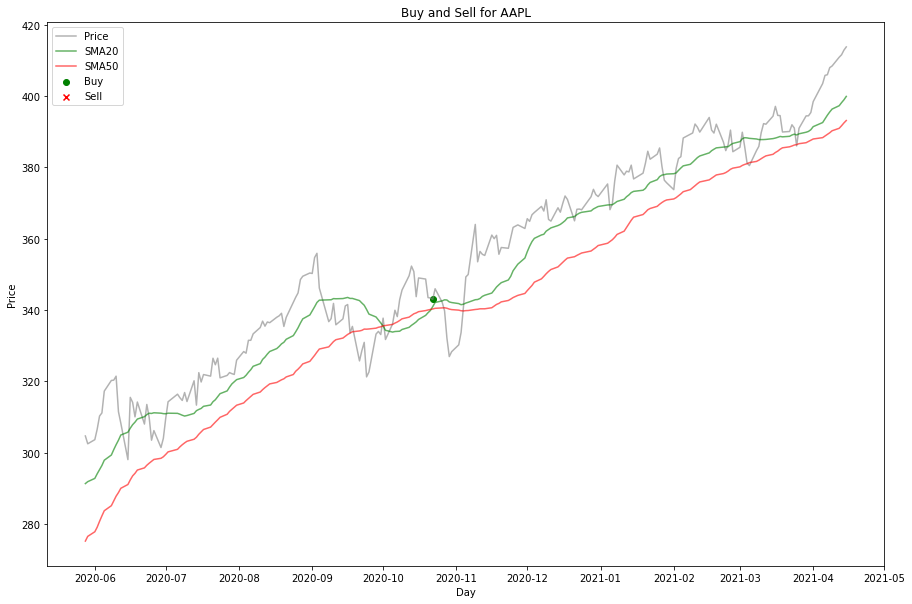

In [15]:
# Visualize SMAs and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

- SPY

Invested: 1000

End of day total balance: 1141.559998

Percentage gain: 14.155999799999995 %

Baseline: 24.141860070036767 %


- AAPL

Invested: 1000

End of day total balance: 993.44

Percentage gain: -0.6559999999999946 %

Baseline: 18.210330494053608 %

- AMZN

Invested: 10000

End of day total balance: 9160.900147

Percentage gain: -8.390998529999997 %

Baseline: 4.559228710335177 %